<a href="https://colab.research.google.com/github/Tatiana-Quilca/CalculadoraApp/blob/master/buenoooo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

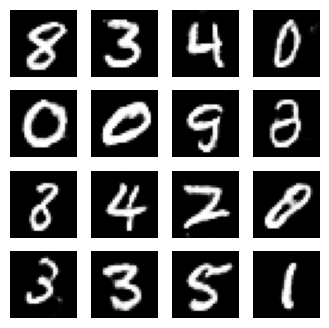

Época 60 [D loss: 1.3350, acc.: 61.76%] [G loss: 0.8755]
Época 60/60, Tiempo: 50.00s


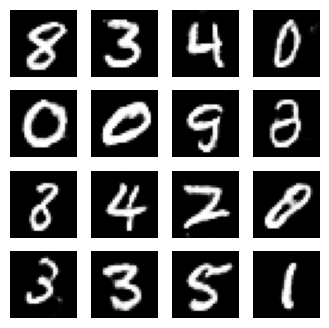


¡Entrenamiento completado!
Generando nuevas imágenes...


NameError: name 'generate_new_images' is not defined

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from IPython.display import clear_output
from tensorflow.keras.models import save_model

# Configuración mejorada de hiperparámetros
class Config:
    BUFFER_SIZE = 60000
    BATCH_SIZE = 256
    EPOCHS = 60
    NOISE_DIM = 100
    NUM_EXAMPLES_TO_GENERATE = 16
    LEARNING_RATE = 1e-4
    BETA_1 = 0.5
    SAMPLE_INTERVAL = 10  # Intervalo para mostrar el progreso

config = Config()

# Cargar y preparar el dataset MNIST
def load_and_prepare_data():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5  # Normalizar a [-1, 1]
    return tf.data.Dataset.from_tensor_slices(train_images).shuffle(config.BUFFER_SIZE).batch(config.BATCH_SIZE)

# Generador mejorado con más capas y mejor estructura
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*512, use_bias=False, input_shape=(config.NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminador mejorado con más capas y mejor estructura
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Funciones de pérdida mejoradas
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * (1 - 0.1), real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizadores mejorados
generator_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)

# Crear los modelos
generator = make_generator_model()
discriminator = make_discriminator_model()

# Checkpoint para guardar el progreso
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

# Función de entrenamiento mejorada
@tf.function
def train_step(images):
    noise = tf.random.normal([config.BATCH_SIZE, config.NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Función para generar y mostrar imágenes mejorada
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def train(dataset, epochs):
    seed = tf.random.normal([config.NUM_EXAMPLES_TO_GENERATE, config.NOISE_DIM])

    for epoch in range(epochs):
        start = time.time()

        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()
        accuracy_metric = tf.keras.metrics.BinaryAccuracy()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg(gen_loss)
            disc_loss_avg(disc_loss)

            # Calcular la precisión del discriminador
            predictions = discriminator(image_batch, training=False)
            binary_predictions = tf.cast(predictions > 0, tf.float32)
            accuracy_metric.update_state(tf.ones_like(binary_predictions), binary_predictions)

        # Guardar checkpoint cada época
        checkpoint.save(file_prefix=checkpoint_prefix)

        # Mostrar progreso en el intervalo especificado
        if (epoch + 1) % config.SAMPLE_INTERVAL == 0:
            clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            print(f"Época {epoch + 1} [D loss: {disc_loss_avg.result():.4f}, acc.: {100*accuracy_metric.result():.2f}%] [G loss: {gen_loss_avg.result():.4f}]")

        print(f'Época {epoch + 1}/{epochs}, Tiempo: {time.time()-start:.2f}s')

    # Generar después del entrenamiento final
    generate_and_save_images(generator, epochs, seed)

# Función principal
def main():
    # Crear directorio para checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    print("Cargando y preparando datos...")
    train_dataset = load_and_prepare_data()

    print(f"\nIniciando entrenamiento por {config.EPOCHS} épocas...")
    train(train_dataset, config.EPOCHS)

    print("\n¡Entrenamiento completado!")
    print("Generando nuevas imágenes...")
    generate_new_images()

    # Guardar los modelos finales
    save_model(generator, 'generator_model_final.h5')
    save_model(discriminator, 'discriminator_model_final.h5')
    print("Modelos guardados como 'generator_model_final.h5' y 'discriminator_model_final.h5'")

if __name__ == "__main__":
    main()
